# Imports and data preps

In [ ]:
# Do all the required impports
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/train.tsv', sep='\t', header=0)
df.head(5)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [ ]:
# removing 1st and 2nd names
# import re

# reg_no_names = '[А-ЯЁ][а-яё]+\s+[А-ЯЁ][а-яё]+(?:\s+[А-ЯЁ][а-яё]+)?'
# df['title'] = [re.sub(reg_no_names, '', i) for i in df['title'].values]

In [ ]:
#lowercase for all 1st to work with navec vocabs
df['title'] = [i.lower() for i in df['title'].values]

In [ ]:
# removing punctuation
# import string

# df['title'] = [i.translate(str.maketrans('', '', string.punctuation)) for i in df['title'].values]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['title'], df['is_fake'], test_size=0.2, random_state=7)

# Neural NEtwork

In [ ]:
!pip install livelossplot
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install navec
from navec import Navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-05-26 13:08:04--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar.3’

navec_news_v1_1B_25 100%[===================>]  25.40M  12.9MB/s    in 2.0s    

2022-05-26 13:08:07 (12.9 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar.3’ saved [26634240/26634240]



In [ ]:
# finds the longest element in our tokens sequence below
def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list

In [ ]:
#TOKENIZER
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'].tolist())
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['title'].tolist())
padded = pad_sequences(sequences, maxlen=longest(sequences), padding='post', truncating='post')

19353


In [ ]:
padded_train = padded[:4500]
padded_test = padded[4500:]

y_train = df['is_fake'].values[:4500]
y_test = df['is_fake'].values[4500:]

In [ ]:
# Import tensor representations for words

embeddings_matrix = np.zeros((vocab_size+1, 300))
for word, i in word_index.items():
  embedding_vector = navec.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector
  else:
    embeddings_matrix[i] = navec['<unk>']

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 300, weights=[embeddings_matrix], trainable=False),
    # tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'],
              loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         5806200   
                                                                 
 dropout_9 (Dropout)         (None, None, 300)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          96064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                      

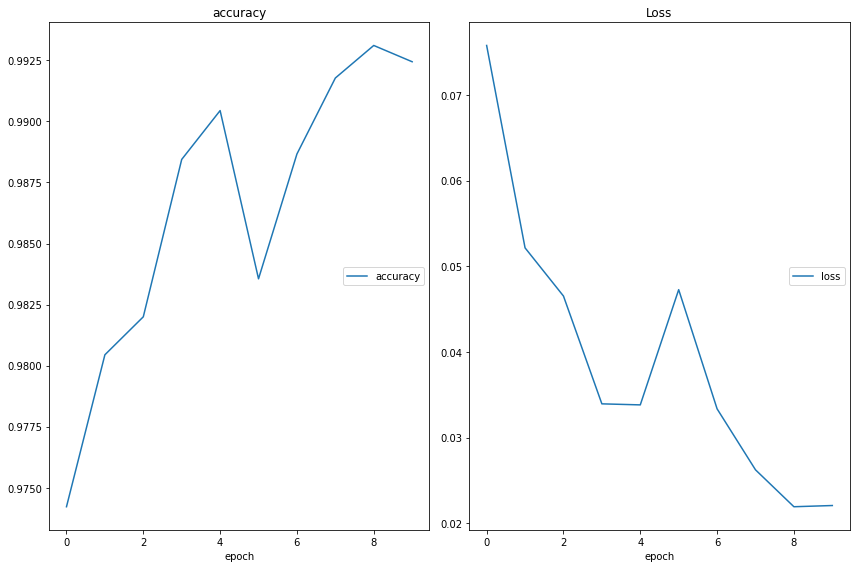

accuracy
	accuracy         	 (min:    0.974, max:    0.993, cur:    0.992)
Loss
	loss             	 (min:    0.022, max:    0.076, cur:    0.022)
141/141 [==============================] - 5s 36ms/step - loss: 0.0221 - accuracy: 0.9924


In [ ]:
history = model.fit(padded_train, y_train, epochs=15, batch_size=32, 
          callbacks = [PlotLossesCallback()])

In [ ]:
NN_preds = model.predict(padded_test)

human_preds = []
for i in NN_preds:
  if i > 0.5: # sigmoid threshold
    human_preds.append(1)
  else:
    human_preds.append(0)

In [ ]:
from sklearn.metrics import accuracy_score
f1_score(y_test, human_preds), accuracy_score(y_test, human_preds)

# f1 = 0.85, accuracy = 0.856 raw data 5 epochs
# f1 = 0.846, accuracy = 0.856 no punctuation 10 epochs
# f1 = 0.855, accuracy = 0.863 lower case 15 epochs BEST CHOICE
# f1 = 0.834, accuracy = 0.849 lower case + no punctuation 5 epochs
# f1 = 0.849, accuracy = 0.854 lower case + no punctuation 15 epochs 

(0.8496302382908792, 0.8545310015898251)

## PassiveAggressiveClassifier

In [ ]:
# Work on vectorizer params
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=5090) # set to 5090, because this is max feature amount for submission dataset
#DataFlair - Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In [ ]:
#DataFlair - Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
#DataFlair - Predict on the test set and calculate f1
y_pred = pac.predict(tfidf_test)
score = f1_score(y_test, y_pred)
print(f'F1_score: {round(score*100, 2)}%')

F1_score: 78.28%


In [ ]:
confusion_matrix(y_test, y_pred)

array([[461, 113],
       [130, 448]])

In [ ]:
# See params for PAC
pac.get_params()

{'C': 1.0,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'fit_intercept': True,
 'loss': 'hinge',
 'max_iter': 50,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# GridSearch fo PAC
skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)
pac = PassiveAggressiveClassifier(n_jobs=-1, random_state=17)

pac_params = {'C': np.arange(0, 1.0, 0.1),
 'average': range(False, True),
 'fit_intercept': range(False, True),
 'max_iter': range(50, 1000, 50),
 'n_iter_no_change': range(1, 5, 1),
 'validation_fraction': np.arange(0.1, 0.5, 0.1),
 'warm_start': range(False, True)}
grid_pac = GridSearchCV(pac, pac_params, cv=skf)

grid_pac.fit(tfidf_train,y_train)
y_pred = grid_pac.predict(tfidf_test)
score = f1_score(y_test, y_pred)
print(f'F1_score: {round(score*100, 2)}%')

# GridSearch improved us by ~2%

F1_score: 80.58%


## RandomForestClassifier

In [ ]:
#DataFlair - Initialize a RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(data_train, y_train)
#DataFlair - Predict on the test set and calculate f1
y_pred_rf = rf.predict(data_test)
score = f1_score(y_test, y_pred_rf)
print(f'F1_score: {round(score*100, 2)}%')

# Let's just forget about it

F1_score: 64.79%


## Catboost

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostClassifier

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
X = df.drop('is_fake', axis=1)
y = df['is_fake']
X_train, X_test, Y_train, Y_test =  train_test_split(
                                      X, y, test_size=0.2, random_state=7)

In [ ]:
model = CatBoostClassifier(random_seed=7,
                           thread_count=-1,
                           verbose=1000,
                           loss_function='Logloss',
                           task_type="CPU")
# Instead of using vectorizers we can just create a Pool by built-in catboost feature, which already knows how to deal with x_train
Train = Pool(data=X_train,
             label=Y_train,
             text_features=['title'])

Test = Pool(data=X_test,
            label=Y_test,
            text_features=['title'])

model.fit(Train, eval_set=Test)
y_pred = model.predict(Test)

score = f1_score(y_test, y_pred)
print(f'F1_score: {round(score*100, 2)}%')

Learning rate set to 0.046212
0:	learn: 0.6754972	test: 0.6730113	best: 0.6730113 (0)	total: 212ms	remaining: 3m 31s
999:	learn: 0.3153737	test: 0.4157681	best: 0.4152289 (851)	total: 2m 44s	remaining: 0us

bestTest = 0.4152288807
bestIteration = 851

Shrink model to first 852 iterations.
F1_score: 80.26%


In [ ]:
# Catboost GridSearch
params_gs = {
            'iterations': [1000],
            # 'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5], 
            # 'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
            # 'depth': [4, 6, 8, 10],
            # 'l2_leaf_reg': [2,3,4],
            # 'min_data_in_leaf': [1, 2, 3, 4]
            }
# Searching through all of these params takes a lifetime, didn't wait that long

model_gs = CatBoostClassifier(random_seed=7,     
                            thread_count=-1,
                            silent=True,  
                            loss_function='Logloss',
                            task_type = "CPU",
                            )

gs_result = model_gs.grid_search(params_gs, 
                              Train, 
                              partition_random_seed=7,
                              verbose=False,
                              plot=False)

y_pred = model_gs.predict(Test)
score = f1_score(y_test, y_pred)
print(f'F1_score: {round(score*100, 2)}%')
# Will use grid_pac model for submission


bestTest = 0.6931642879
bestIteration = 0

Training on fold [0/3]

bestTest = 0.4364906392
bestIteration = 989

Training on fold [1/3]

bestTest = 0.4526844333
bestIteration = 491

Training on fold [2/3]

bestTest = 0.4651145165
bestIteration = 512

F1_score: 80.66%
